# ASHRAE - Great Energy Predictor III


Our aim in this competition is to predict energy consumption of buildings.

There are 4 types of energy to predict:

 - 0: electricity
 - 1: chilledwater
 - 2: steam
 - 3: hotwater

Electricity and water consumption may have different behavior!
So I tried to separately train & predict the model.

I moved previous [ASHRAE: Simple LGBM submission](https://www.kaggle.com/corochann/ashrae-simple-lgbm-submission) kernel.

**[Update] I published "[Optuna tutorial for hyperparameter optimization](https://www.kaggle.com/corochann/optuna-tutorial-for-hyperparameter-optimization)" notebook.
Please also check it :)**

In [68]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import holidays

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold, TimeSeriesSplit
import lightgbm as lgb
import xgboost as xgb
import catboost as cb


In [69]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Fast data loading

This kernel uses the preprocessed data from my previous kernel, [
ASHRAE: feather format for fast loading](https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading), to accelerate data loading!

In [70]:
#%%time
root = Path('../data')

train_df = pd.read_csv(root/'train.csv')
weather_train_df = pd.read_csv(root/'weather_train_tz_fix.csv')
building_meta_df = pd.read_csv(root/'building_metadata.csv')

nasa_weather_df=pd.read_csv(root/'nasa_weather.csv')


In [71]:
nasa_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17552 entries, 0 to 17551
Data columns (total 10 columns):
ALLSKY_SFC_LW_DWN    17552 non-null float64
ALLSKY_SFC_SW_DWN    17552 non-null float64
ALLSKY_TOA_SW_DWN    17552 non-null float64
CDD0                 17552 non-null float64
CDD10                17552 non-null float64
CLRSKY_SFC_SW_DWN    17552 non-null float64
HDD18_3              17552 non-null float64
T2M                  17552 non-null float64
Date                 17552 non-null object
site_id              17552 non-null int64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [72]:
nasa_weather_df.head()

,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_SW_DWN,ALLSKY_TOA_SW_DWN,CDD0,CDD10,CLRSKY_SFC_SW_DWN,HDD18_3,T2M,Date,site_id
0,9.53,0.95,5.47,18.19,8.19,-999.0,0.11,18.75,2016-01-01,0
1,9.07,1.45,5.48,14.33,4.33,-999.0,3.97,13.69,2016-01-02,0
2,8.73,1.16,5.50,10.60,0.60,-999.0,7.70,10.62,2016-01-03,0
3,6.93,3.76,5.51,11.17,1.17,3.8,7.13,10.25,2016-01-04,0
4,7.54,2.01,5.53,9.35,0.00,-999.0,8.95,9.20,2016-01-05,0


In [73]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
#test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
#weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

In [74]:
nasa_weather_df.rename(columns={'Date':'date'}, inplace=True)

In [75]:
nasa_weather_df['date']=pd.to_datetime(nasa_weather_df['date']).dt.date
weather_train_df['date'] = weather_train_df['timestamp'].dt.date

In [76]:
weather_train_df=weather_train_df.merge(nasa_weather_df, on=['site_id', 'date'], how='left')
weather_train_df.drop(columns='date',inplace=True)

In [77]:
weather_train_df.head(20)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_SW_DWN,ALLSKY_TOA_SW_DWN,CDD0,CDD10,CLRSKY_SFC_SW_DWN,HDD18_3,T2M
0,0,2015-12-31 19:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2015-12-31 20:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2015-12-31 21:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2015-12-31 22:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2015-12-31 23:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,2016-01-01 00:00:00,19.4,NaN,19.4,0.0,NaN,0.0,0.0,9.53,0.95,5.47,18.19,8.19,-999.0,0.11,18.75
6,0,2016-01-01 01:00:00,21.1,6.0,21.1,-1.0,1019.4,0.0,0.0,9.53,0.95,5.47,18.19,8.19,-999.0,0.11,18.75
7,0,2016-01-01 02:00:00,21.1,NaN,21.1,0.0,1018.8,210.0,1.5,9.53,0.95,5.47,18.19,8.19,-999.0,0.11,18.75
8,0,2016-01-01 03:00:00,20.6,NaN,20.0,0.0,1018.1,0.0,0.0,9.53,0.95,5.47,18.19,8.19,-999.0,0.11,18.75
9,0,2016-01-01 04:00:00,21.1,NaN,20.6,0.0,1019.0,290.0,1.5,9.53,0.95,5.47,18.19,8.19,-999.0,0.11,18.75


In [78]:
def weather_process(df):
    site_id_location_mapping={0:'US', 1:'UK', 2: 'US', 3: 'US', 4: 'US', 5: 'UK', 6:'US', 7:'CA', 8: 'US', 9: 'US', 10: 'US', 11:'CA', 12:'IE', 13:'US', 14: 'US', 15: 'US'}
    hlds={site_id: pd.DatetimeIndex(holidays.CountryHoliday(site_id_location_mapping[site_id], years=[2016, 2017, 2018]).keys()) for site_id in site_id_location_mapping}
    
    df['date_index']=pd.DatetimeIndex(pd.to_datetime(df['timestamp']).dt.date)
    df['is_holiday']=df.apply(lambda row: row['date_index'] in hlds[row['site_id']], axis=1).astype(int)
    df.drop(columns='date_index', inplace=True)
    
    del site_id_location_mapping, hlds

weather_process(weather_train_df)

In [79]:
train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

In [182]:
def plot_date_usage(train_df, test_df=None, meter=0, building_id=0):
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    
    plt.subplots(figsize=(20,10))
    
    fig = sns.lineplot(x='date', y='meter_reading_log1p', data=train_temp_df_meter)
    
    if test_df is not None:
            test_temp_df = test_df[test_df['meter'] == meter]
            test_temp_df = test_temp_df[test_temp_df['building_id'] == building_id]    
            test_temp_df_meter = test_temp_df.groupby('date')['meter_reading_log1p'].sum()
            test_temp_df_meter = test_temp_df_meter.to_frame().reset_index()
            fig = sns.lineplot(x='date', y='meter_reading_log1p', data=test_temp_df_meter)
    
    plt.legend(['Train', 'Predicted'])

    plt.show()
    
    del train_temp_df, train_temp_df_meter

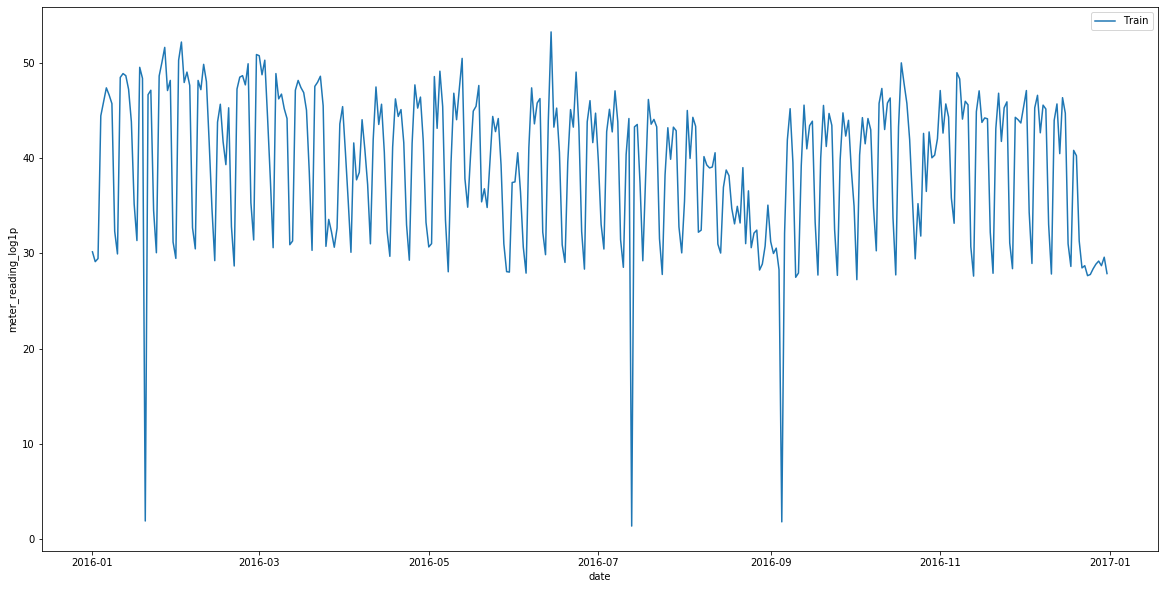

In [202]:
plot_date_usage(train_df=train_df, test_df=None, meter=0, building_id=666)

## Removing weired data on site_id 0

As you can see above, this data looks weired until May 20. It is reported in [this discussion](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113054#656588) by @barnwellguy that **All electricity meter is 0 until May 20 for site_id == 0**. I will remove these data from training data.

It corresponds to `building_id <= 104`.

In [82]:
building_meta_df[building_meta_df.site_id == 0]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
100,0,100,Lodging/residential,24456,1968.0,NaN
101,0,101,Office,18860,1986.0,NaN
102,0,102,Office,15876,1983.0,NaN
103,0,103,Education,21657,2016.0,NaN


In [160]:
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

#### Lets perform log1p transformation for "square_feet" in building_meta_df

In [84]:
building_meta_df['square_feet']=np.log1p(building_meta_df['square_feet'])

# Data preprocessing

Now, Let's try building GBDT (Gradient Boost Decision Tree) model to predict `meter_reading_log1p`. I will try using LightGBM in this notebook.

In [85]:
debug = False

# Add time feature

Some features introduced in https://www.kaggle.com/ryches/simple-lgbm-solution by @ryches

Features that are likely predictive:

#### Weather

- time of day
- is_holiday
- weekend
- educational vacation
- cloud_coverage + lags
- dew_temperature + lags
- precip_depth + lags
- sea_level_pressure + lags
- wind_direction + lags
- wind_speed + lags


#### NASA Daily Average Weather

- T2M Temperature at 2 Meters (C) 
- ALLSKY_TOA_SW_DWN Top-of-atmosphere Insolation (kW-hr/m^2/day) 
- CDD10Cooling Degree Days Above 10 C (Degree C-d) 
- ALLSKY_SFC_LW_DWN Downward Thermal Infrared (Longwave) Radiative Flux (kW-hr/m^2/day) 
- ALLSKY_SFC_SW_DWN Sky Insolation Incident on a Horizontal Surface (kW-hr/m^2/day) 
- CDD0 Cooling Degree Days Above 0 C (Degree C-d) 
- HDD18_3 Heating Degree Days Below 18.3 C (Degree C-d) 
- CLRSKY_SFC_SW_DWN Clear Sky Insolation Incident on a Horizontal Surface (kW-hr/m^2/day) (MAINLY -999 will not be used)



#### Train

- max, mean, min, std of the specific building historically



However we should be careful of putting time feature, since we have only 1 year data in training,
including `date` makes overfiting to training data.

How about `month`? It may be better to check performance by cross validation.
I go not using this data in this kernel for robust modeling.

In [86]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
    df["day"] = df["timestamp"].dt.day
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek
   
   
#    df['edc_vacation']=

#     hour_rad = df["hour"].values / 24. * 2 * np.pi
#     df["hour_sin"] = np.sin(hour_rad)
#     df["hour_cos"] = np.cos(hour_rad)

In [87]:
preprocess(train_df)

In [88]:
df_group = train_df.groupby('building_id')['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

train_df['building_mean'] = train_df['building_id'].map(building_mean)
train_df['building_median'] = train_df['building_id'].map(building_median)
train_df['building_min'] = train_df['building_id'].map(building_min)
train_df['building_max'] = train_df['building_id'].map(building_max)
train_df['building_std'] = train_df['building_id'].map(building_std)

In [89]:
building_mean.head()

building_id
0    5.433594
1    4.761719
2    2.998047
3    5.875000
4    7.343750
Name: meter_reading_log1p, dtype: float16

# Fill Nan value in weather dataframe by interpolation


weather data has a lot of NaNs!!

![](http://)I tried to fill these values by **interpolating** data.

In [90]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_SW_DWN,ALLSKY_TOA_SW_DWN,CDD0,CDD10,CLRSKY_SFC_SW_DWN,HDD18_3,T2M,is_holiday
0,0,2015-12-31 19:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0,2015-12-31 20:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0,2015-12-31 21:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0,2015-12-31 22:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0,2015-12-31 23:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [91]:
# weather_train_df.describe()

In [92]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69168
dew_temperature         113
precip_depth_1_hr     50284
sea_level_pressure    10617
wind_direction         6268
wind_speed              304
ALLSKY_SFC_LW_DWN        68
ALLSKY_SFC_SW_DWN        68
ALLSKY_TOA_SW_DWN        68
CDD0                     68
CDD10                    68
CLRSKY_SFC_SW_DWN        68
HDD18_3                  68
T2M                      68
is_holiday                0
dtype: int64

In [93]:
weather_train_df.shape

(139759, 18)

In [94]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_SW_DWN,ALLSKY_TOA_SW_DWN,CDD0,CDD10,CLRSKY_SFC_SW_DWN,HDD18_3,T2M,is_holiday
site_id,,,,,,,,,,,,,,,,,,
0,0,0,3,3830,3,1,85,250,0,5,5,5,5,5,5,5,5,0
1,0,0,1,7061,1,8762,52,3,0,0,0,0,0,0,0,0,0,0
2,0,0,1,2354,1,66,44,591,5,7,7,7,7,7,7,7,7,0
3,0,0,4,3642,6,37,158,153,4,5,5,5,5,5,5,5,5,0
4,0,0,0,4229,2,1317,73,105,0,7,7,7,7,7,7,7,7,0
5,0,0,2,6029,2,8754,8754,295,3,0,0,0,0,0,0,0,0,0
6,0,0,10,2992,10,0,175,779,39,4,4,4,4,4,4,4,4,0
7,0,0,0,8613,23,7882,8,0,0,5,5,5,5,5,5,5,5,0
8,0,0,3,3830,3,1,85,250,0,5,5,5,5,5,5,5,5,0


In [95]:
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [96]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_SW_DWN,ALLSKY_TOA_SW_DWN,CDD0,CDD10,CLRSKY_SFC_SW_DWN,HDD18_3,T2M,is_holiday
site_id,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,8762,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,8754,8754,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,8613,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Seems number of nan has reduced by `interpolate` but some property has never appear in specific `site_id`, and nan remains for these features.

## lags

Adding some lag feature

In [97]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [98]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

In [99]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,ALLSKY_SFC_LW_DWN,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2015-12-31 19:00:00,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,9.53,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2015-12-31 20:00:00,24.4,4.0,21.1,-1.0,1020.2,70.0,1.5,9.53,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2015-12-31 21:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,9.53,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2015-12-31 22:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,9.53,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2015-12-31 23:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,9.53,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477


In [100]:
weather_train_df.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'ALLSKY_SFC_LW_DWN',
       'ALLSKY_SFC_SW_DWN', 'ALLSKY_TOA_SW_DWN', 'CDD0', 'CDD10',
       'CLRSKY_SFC_SW_DWN', 'HDD18_3', 'T2M', 'is_holiday',
       'air_temperature_mean_lag3', 'air_temperature_max_lag3',
       'air_temperature_min_lag3', 'air_temperature_std_lag3',
       'cloud_coverage_mean_lag3', 'cloud_coverage_max_lag3',
       'cloud_coverage_min_lag3', 'cloud_coverage_std_lag3',
       'dew_temperature_mean_lag3', 'dew_temperature_max_lag3',
       'dew_temperature_min_lag3', 'dew_temperature_std_lag3',
       'precip_depth_1_hr_mean_lag3', 'precip_depth_1_hr_max_lag3',
       'precip_depth_1_hr_min_lag3', 'precip_depth_1_hr_std_lag3',
       'sea_level_pressure_mean_lag3', 'sea_level_pressure_max_lag3',
       'sea_level_pressure_min_lag3', 'sea_level_pressure_std_lag3',
       'wind_direction_mea

In [101]:
# categorize primary_use column to reduce memory on merge...

primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


140

In [102]:
reduce_mem_usage(train_df, use_float16=True)
reduce_mem_usage(building_meta_df, use_float16=True)
reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 2008.64 MB
Memory usage after optimization is: 795.89 MB
Decreased by 60.4%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.01 MB
Decreased by 79.0%
Memory usage of dataframe is 34.65 MB
Memory usage after optimization is: 21.33 MB
Decreased by 38.5%


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,ALLSKY_SFC_LW_DWN,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2015-12-31 19:00:00,25.000000,6.0,20.000000,-1.0,1019.5,0.0,0.000000,9.53125,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2015-12-31 20:00:00,24.406250,4.0,21.093750,-1.0,1020.0,70.0,1.500000,9.53125,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2015-12-31 21:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000,9.53125,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2015-12-31 22:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000,9.53125,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2015-12-31 23:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609,9.53125,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139754,15,2016-12-31 14:00:00,3.000000,1.5,-8.000000,-1.0,1007.5,180.0,5.699219,6.71875,...,1000.0,6.726562,211.000000,310.0,0.0,72.00000,5.046875,11.296875,0.0,2.525391
139755,15,2016-12-31 15:00:00,2.800781,2.0,-8.898438,-1.0,1007.5,180.0,7.699219,6.71875,...,1000.0,6.578125,209.875000,310.0,0.0,71.87500,5.125000,11.296875,0.0,2.519531
139756,15,2016-12-31 16:00:00,2.800781,2.0,-7.199219,-1.0,1007.5,180.0,5.101562,6.71875,...,1000.0,6.421875,212.375000,310.0,0.0,67.43750,5.195312,11.296875,0.0,2.443359
139757,15,2016-12-31 17:00:00,2.199219,2.0,-6.699219,-1.0,1008.0,170.0,4.601562,6.71875,...,1000.0,6.246094,211.375000,310.0,0.0,67.56250,5.226562,11.296875,0.0,2.423828


In [103]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,8.914062,2008.0,NaN
1,0,1,0,7.910156,2004.0,NaN
2,0,2,0,8.593750,1991.0,NaN
3,0,3,0,10.070312,2002.0,NaN
4,0,4,0,11.664062,1975.0,NaN


# Train model

To win in kaggle competition, how to evaluate your model is important.
What kind of cross validation strategy is suitable for this competition? This is time series data, so it is better to consider time-splitting.

However this notebook is for simple tutorial, so I will proceed with KFold splitting without shuffling, so that at least near-term data is not included in validation.

In [104]:
category_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'dayofweek', 'day', # 'month' , , 'weekend' 'school vacation'
    'is_holiday',
    'building_median'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed', 'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72', 'wind_direction_mean_lag72',
    'wind_speed_mean_lag72', 'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3', 'sea_level_pressure_mean_lag3',
    'wind_direction_mean_lag3', 'wind_speed_mean_lag3'] + [
    'ALLSKY_SFC_LW_DWN',
    'ALLSKY_SFC_SW_DWN', 'ALLSKY_TOA_SW_DWN', 'CDD0', 'CDD10',
    #'CLRSKY_SFC_SW_DWN',
    'HDD18_3', 'T2M']

In [105]:
#rank_gauss
def rank_gauss(x):
    from scipy.special import erfinv
    N = x.shape[0]
    temp = x.argsort()
    rank_x = temp.argsort() / N
    rank_x -= rank_x.mean()
    rank_x *= 2
    efi_x = erfinv(rank_x)
    efi_x -= efi_x.mean()
    return efi_x





In [106]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

In [107]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
#               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 50
    verbose_eval = 25

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [108]:
folds = 5
seed = 666
shuffle = True
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
tscv = TimeSeriesSplit(n_splits=folds)

# Train model by each meter type

target_meter 0 (11714696, 43)
cat_features [40, 41, 42]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 50 rounds.
[25]	training's l2: 0.566058	valid_1's l2: 0.566368
[50]	training's l2: 0.368598	valid_1's l2: 0.368954
[75]	training's l2: 0.316971	valid_1's l2: 0.317223
[100]	training's l2: 0.277219	valid_1's l2: 0.277456
[125]	training's l2: 0.247298	valid_1's l2: 0.247709
[150]	training's l2: 0.226359	valid_1's l2: 0.226803
[175]	training's l2: 0.210632	valid_1's l2: 0.211156
[200]	training's l2: 0.196509	valid_1's l2: 0.19722
[225]	training's l2: 0.186896	valid_1's l2: 0.187621
[250]	training's l2: 0.178795	valid_1's l2: 0.179577
[275]	training's l2: 0.170877	valid_1's l2: 0.171735
[300]	training's l2: 0.164827	valid_1's l2: 0.165716
[325]	training's l2: 0.159633	valid_1's l2: 0.160592
[350]	training's l2: 0.154808	valid_1's l2: 0.155875
[375]	training's l2: 0.151024	valid_1's l2: 0.152127
[400]	training's l2: 0.146728	valid_1's l2: 0.147

10

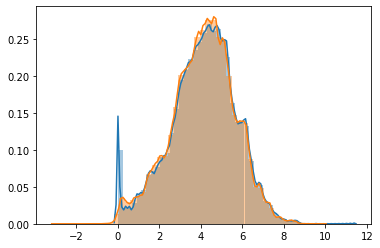

In [109]:
target_meter = 0
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

for i in X_train[feature_cols].columns:
    X_train[i] = rank_gauss(X_train[i].values)

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)
del X_train, y_train
gc.collect()

In [110]:
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

target_meter 1 (4182440, 43)
cat_features [40, 41, 42]
train 3345952 valid 836488
training LGB:
Training until validation scores don't improve for 50 rounds.
[25]	training's l2: 2.13148	valid_1's l2: 2.13014
[50]	training's l2: 1.51091	valid_1's l2: 1.51151
[75]	training's l2: 1.2902	valid_1's l2: 1.29255
[100]	training's l2: 1.15387	valid_1's l2: 1.15626
[125]	training's l2: 1.07055	valid_1's l2: 1.07254
[150]	training's l2: 1.01454	valid_1's l2: 1.01614
[175]	training's l2: 0.968078	valid_1's l2: 0.969682
[200]	training's l2: 0.92907	valid_1's l2: 0.931031
[225]	training's l2: 0.900471	valid_1's l2: 0.902598
[250]	training's l2: 0.875216	valid_1's l2: 0.877816
[275]	training's l2: 0.849351	valid_1's l2: 0.852491
[300]	training's l2: 0.826157	valid_1's l2: 0.829616
[325]	training's l2: 0.807911	valid_1's l2: 0.811784
[350]	training's l2: 0.789966	valid_1's l2: 0.794262
[375]	training's l2: 0.776167	valid_1's l2: 0.780838
[400]	training's l2: 0.762805	valid_1's l2: 0.767947
[425]	train

10

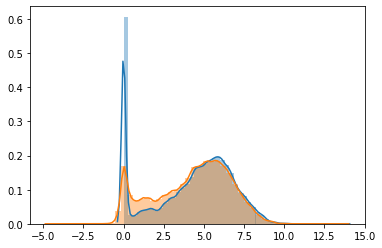

In [111]:
target_meter = 1
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

for i in X_train[feature_cols].columns:
    X_train[i] = rank_gauss(X_train[i].values)

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)
del X_train, y_train
gc.collect()

target_meter 2 (2708713, 43)
cat_features [40, 41, 42]
train 2166970 valid 541743
training LGB:
Training until validation scores don't improve for 50 rounds.
[25]	training's l2: 2.30024	valid_1's l2: 2.30364
[50]	training's l2: 1.64914	valid_1's l2: 1.65375
[75]	training's l2: 1.44742	valid_1's l2: 1.4529
[100]	training's l2: 1.3303	valid_1's l2: 1.33556
[125]	training's l2: 1.24832	valid_1's l2: 1.25437
[150]	training's l2: 1.19266	valid_1's l2: 1.19945
[175]	training's l2: 1.14463	valid_1's l2: 1.15225
[200]	training's l2: 1.10825	valid_1's l2: 1.11665
[225]	training's l2: 1.07925	valid_1's l2: 1.08821
[250]	training's l2: 1.04879	valid_1's l2: 1.0585
[275]	training's l2: 1.02443	valid_1's l2: 1.03475
[300]	training's l2: 1.00563	valid_1's l2: 1.0166
[325]	training's l2: 0.98714	valid_1's l2: 0.998881
[350]	training's l2: 0.967837	valid_1's l2: 0.98015
[375]	training's l2: 0.950576	valid_1's l2: 0.963438
[400]	training's l2: 0.937783	valid_1's l2: 0.950964
[425]	training's l2: 0.9243

10

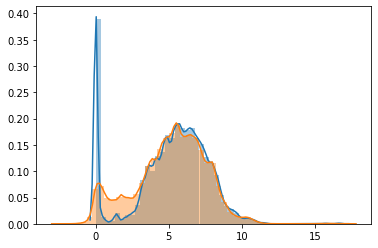

In [112]:
target_meter = 2
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

for i in X_train[feature_cols].columns:
    X_train[i] = rank_gauss(X_train[i].values)


gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)
del X_train, y_train
gc.collect()

target_meter 3 (1264037, 43)
cat_features [40, 41, 42]
train 1011229 valid 252808
training LGB:
Training until validation scores don't improve for 50 rounds.
[25]	training's l2: 3.19585	valid_1's l2: 3.19652
[50]	training's l2: 2.23632	valid_1's l2: 2.23808
[75]	training's l2: 1.92303	valid_1's l2: 1.92541
[100]	training's l2: 1.77649	valid_1's l2: 1.7793
[125]	training's l2: 1.67286	valid_1's l2: 1.67621
[150]	training's l2: 1.58894	valid_1's l2: 1.59223
[175]	training's l2: 1.53325	valid_1's l2: 1.53734
[200]	training's l2: 1.49567	valid_1's l2: 1.50063
[225]	training's l2: 1.45985	valid_1's l2: 1.46579
[250]	training's l2: 1.4266	valid_1's l2: 1.43334
[275]	training's l2: 1.40165	valid_1's l2: 1.40923
[300]	training's l2: 1.37707	valid_1's l2: 1.38523
[325]	training's l2: 1.35623	valid_1's l2: 1.36539
[350]	training's l2: 1.33441	valid_1's l2: 1.34421
[375]	training's l2: 1.31468	valid_1's l2: 1.32482
[400]	training's l2: 1.29967	valid_1's l2: 1.31051
[425]	training's l2: 1.28372	va

10

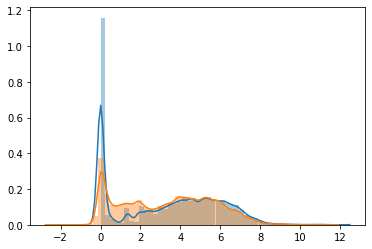

In [113]:
target_meter = 3
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

for i in X_train[feature_cols].columns:
    X_train[i] = rank_gauss(X_train[i].values)


gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)
del X_train, y_train
gc.collect()

# Prediction on test data

In [114]:
print('loading...')
test_df = pd.read_csv(root/'test.csv')
weather_test_df = pd.read_csv(root/'weather_test_tz_fix.csv')

print('preprocessing building...')
test_df['timestamp']=pd.to_datetime(test_df['timestamp'])
weather_test_df['timestamp']=pd.to_datetime(weather_test_df['timestamp'])
test_df['date'] = test_df['timestamp'].dt.date

weather_test_df['date'] = weather_test_df['timestamp'].dt.date
weather_test_df=weather_test_df.merge(nasa_weather_df, on=['site_id', 'date'], how='left')
weather_test_df.drop(columns='date',inplace=True)
weather_process(weather_test_df)

preprocess(test_df)
test_df['building_mean'] = test_df['building_id'].map(building_mean)
test_df['building_median'] = test_df['building_id'].map(building_median)
test_df['building_min'] = test_df['building_id'].map(building_min)
test_df['building_max'] = test_df['building_id'].map(building_max)
test_df['building_std'] = test_df['building_id'].map(building_std)

print('preprocessing weather...')
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

print('reduce mem usage...')
reduce_mem_usage(test_df, use_float16=True)
reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

loading...
preprocessing building...
preprocessing weather...
reduce mem usage...
Memory usage of dataframe is 3578.93 MB
Memory usage after optimization is: 1272.53 MB
Decreased by 64.4%
Memory usage of dataframe is 68.74 MB
Memory usage after optimization is: 42.30 MB
Decreased by 38.5%


561

In [115]:
sample_submission = pd.read_csv(os.path.join(root, 'sample_submission.csv'))
reduce_mem_usage(sample_submission)

Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [116]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [117]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)
    print('samples', X_test.shape[0])

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += np.expm1(y_pred_test)

    y_test_pred_total /= len(models)
    print('y_samples',y_test_pred_total.shape[0])
    return y_test_pred_total


iterations 25
samples 24755760
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



y_samples 24755760


166

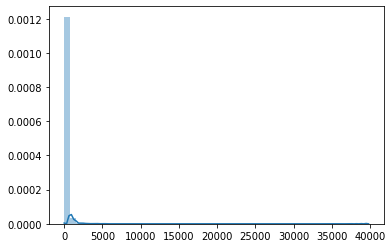

In [118]:
#%%time
X_test = create_X(test_df, target_meter=0)
gc.collect()


for i in X_test[feature_cols].columns:
    X_test[i] = rank_gauss(X_test[i].values)



y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

del X_test
gc.collect()

iterations 9
samples 8724960
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



y_samples 8724960


212

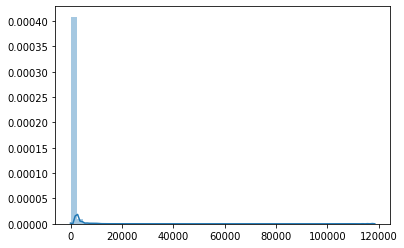

In [119]:
#%%time
X_test = create_X(test_df, target_meter=1)
gc.collect()

for i in X_test[feature_cols].columns:
    X_test[i] = rank_gauss(X_test[i].values)


y_test1 = pred(X_test, models1)
sns.distplot(y_test1)

del X_test
gc.collect()

iterations 6
samples 5676480
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



y_samples 5676480


303

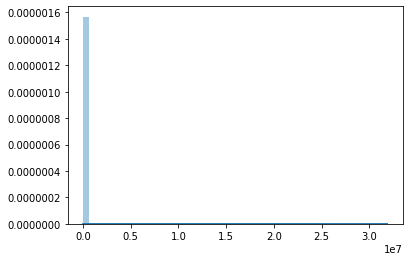

In [120]:
#%%time
X_test = create_X(test_df, target_meter=2)
gc.collect()

for i in X_test[feature_cols].columns:
    X_test[i] = rank_gauss(X_test[i].values)


y_test2 = pred(X_test, models2)
sns.distplot(y_test2)

del X_test
gc.collect()

iterations 3
samples 2540400
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



y_samples 2540400


113

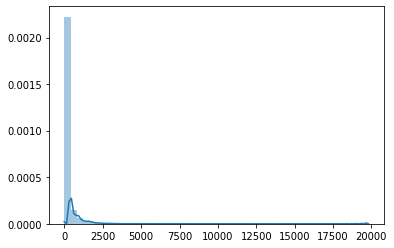

In [121]:
X_test = create_X(test_df, target_meter=3)
gc.collect()

for i in X_test[feature_cols].columns:
    X_test[i] = rank_gauss(X_test[i].values)


y_test3 = pred(X_test, models3)
sns.distplot(y_test3)

del X_test
gc.collect()

In [123]:
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = y_test0
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = y_test1
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = y_test2
sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = y_test3
sample_submission['meter_reading'].clip(lower=0, inplace=True)

In [124]:
sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')

In [125]:
sample_submission.sample(10)

,row_id,meter_reading
20984052,20984052,135.597638
22669079,22669079,189.067550
34404904,34404904,765.093004
11708706,11708706,11.122165
26094565,26094565,1.077214
5429043,5429043,96.307102
34168780,34168780,16.119984
33561710,33561710,123.700439
12387858,12387858,7.849878
31785987,31785987,89.752161


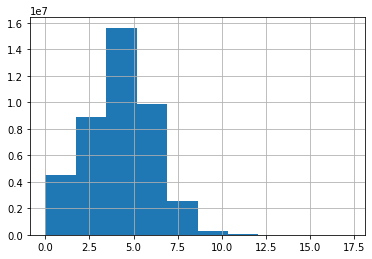

In [126]:
np.log1p(sample_submission['meter_reading']).hist()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



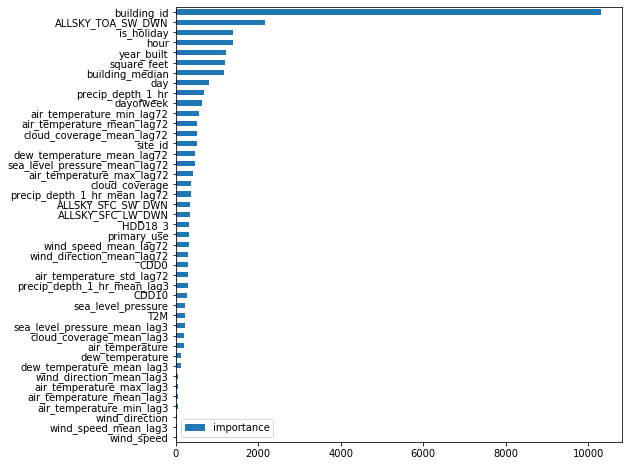

In [127]:
plot_feature_importance(models0[1])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



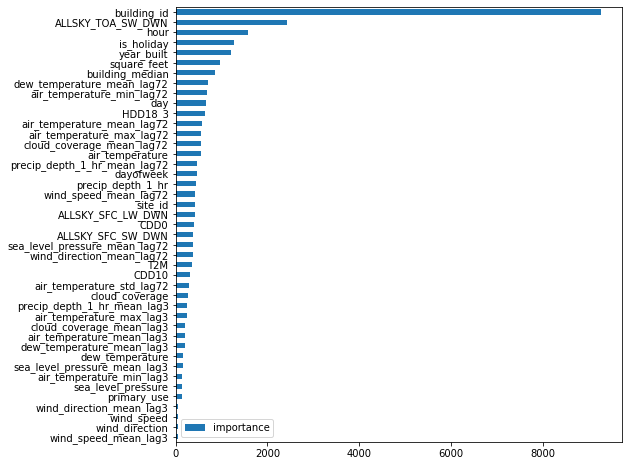

In [128]:
plot_feature_importance(models1[1])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



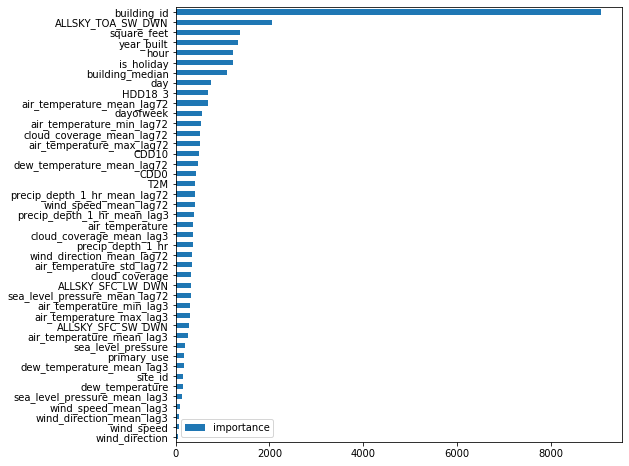

In [129]:
plot_feature_importance(models2[1])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



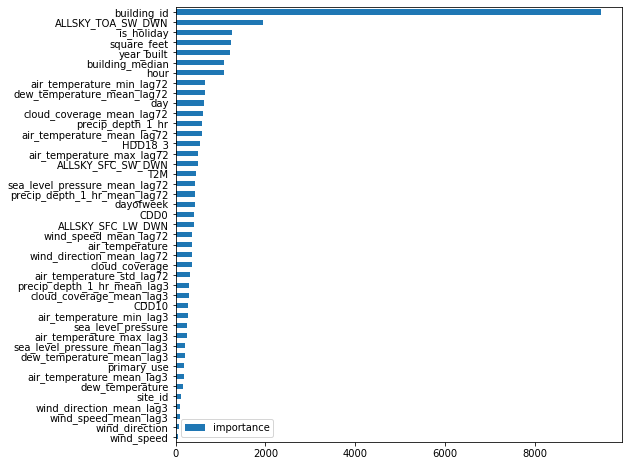

In [130]:
plot_feature_importance(models3[1])

In [133]:
test_df.head()

,row_id,building_id,meter,timestamp,date,hour,day,weekend,month,dayofweek,building_mean,building_median,building_min,building_max,building_std,meter_reading
0,0,0,0,2017-01-01,2017-01-01,0,1,6,1,6,5.433594,5.488281,0.0,5.804688,0.392578,107.263520
1,1,1,0,2017-01-01,2017-01-01,0,1,6,1,6,4.761719,4.890625,0.0,5.390625,0.359619,48.906606
2,2,2,0,2017-01-01,2017-01-01,0,1,6,1,6,2.998047,3.066406,0.0,4.234375,0.686523,4.876137
3,3,3,0,2017-01-01,2017-01-01,0,1,6,1,6,5.875000,5.914062,0.0,6.488281,0.502441,186.876307
4,4,4,0,2017-01-01,2017-01-01,0,1,6,1,6,7.343750,7.375000,0.0,7.570312,0.421875,972.684700


In [132]:
test_df=test_df.merge(sample_submission, on=['row_id'])
test_df['meter_reading_log1p']=np.log1p(test_df['meter_reading'])

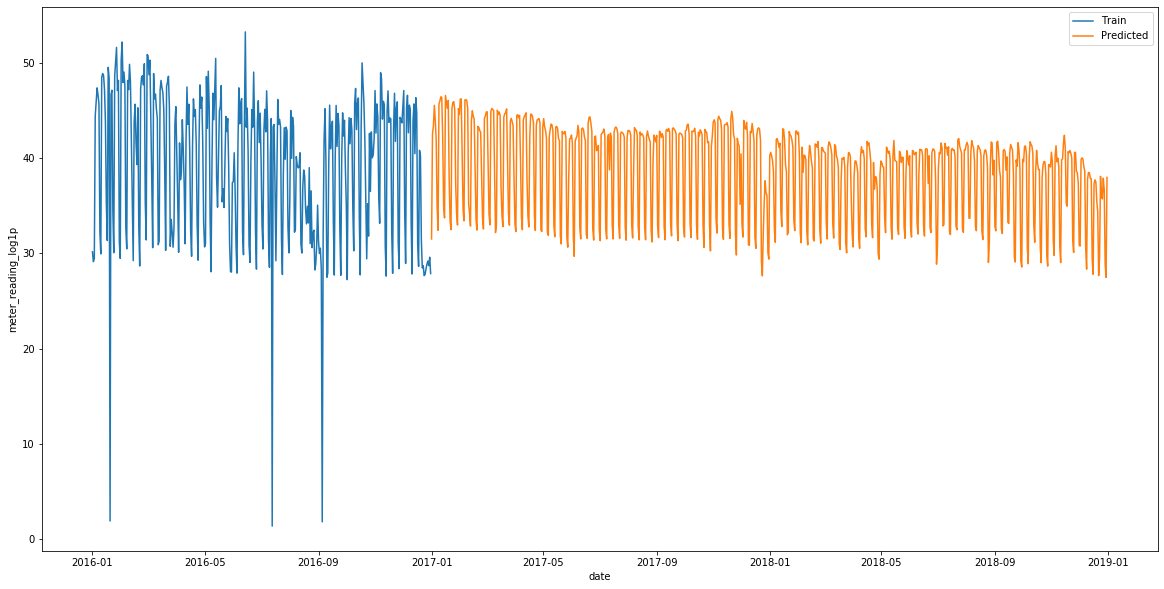

In [203]:
plot_date_usage(train_df=train_df, test_df=test_df, building_id=666, meter=0)

# References

These kernels inspired me to write this kernel, thank you for sharing!

 - https://www.kaggle.com/rishabhiitbhu/ashrae-simple-eda
 - https://www.kaggle.com/isaienkov/simple-lightgbm
 - https://www.kaggle.com/ryches/simple-lgbm-solution